
Training network with 4 hidden neurons:
 Epoch 0, Error: 4.308601
 Epoch 1000, Error: 2.284838
 Epoch 2000, Error: 0.845378
 Epoch 3000, Error: 0.742148
 Epoch 4000, Error: 0.020395
 Epoch 5000, Error: 0.010206
 Epoch 6000, Error: 0.007075
 Epoch 7000, Error: 0.005473
 Epoch 8000, Error: 0.004482
 Epoch 9000, Error: 0.003803
Predictions: [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy: 100.00%

Training network with 6 hidden neurons:
 Epoch 0, Error: 4.101412
 Epoch 1000, Error: 0.905391
 Epoch 2000, Error: 0.033691
 Epoch 3000, Error: 0.013322
 Epoch 4000, Error: 0.008043
 Epoch 5000, Error: 0.005711
 Epoch 6000, Error: 0.004415
 Epoch 7000, Error: 0.003593
 Epoch 8000, Error: 0.003027
 Epoch 9000, Error: 0.002614
Predictions: [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Accuracy: 100.00%

Training network with 8 hidden neurons:
 Epoch 0, Error: 4.321367
 Epoch 1000, Error: 1.770735
 Epoch 2000, Error: 0.390185
 Epoch 3000, Error: 0.025121
 Epoch 4000, Error: 0.010685
 

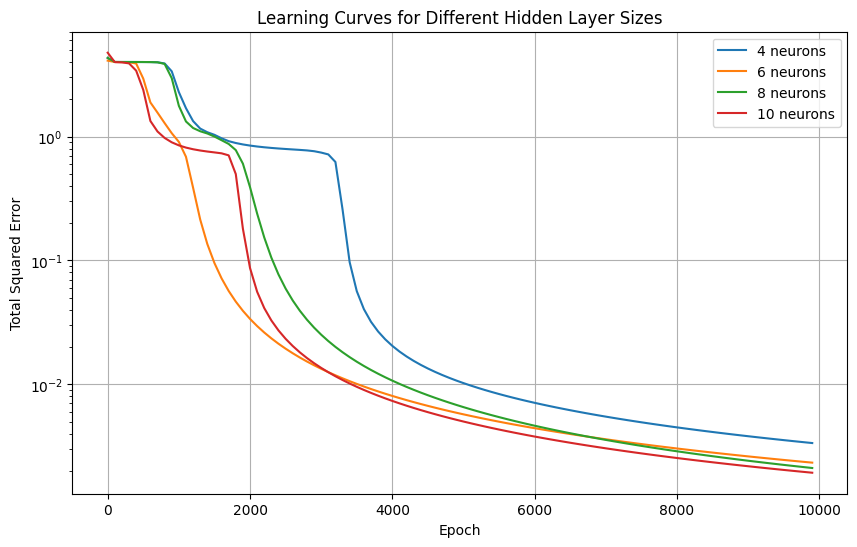

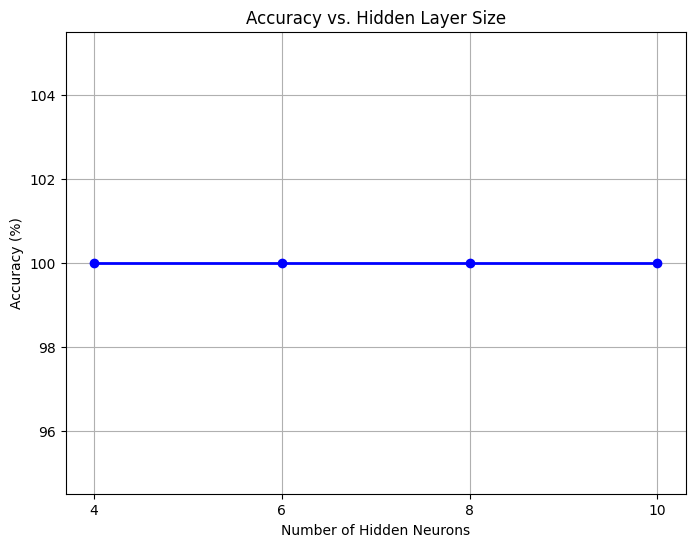

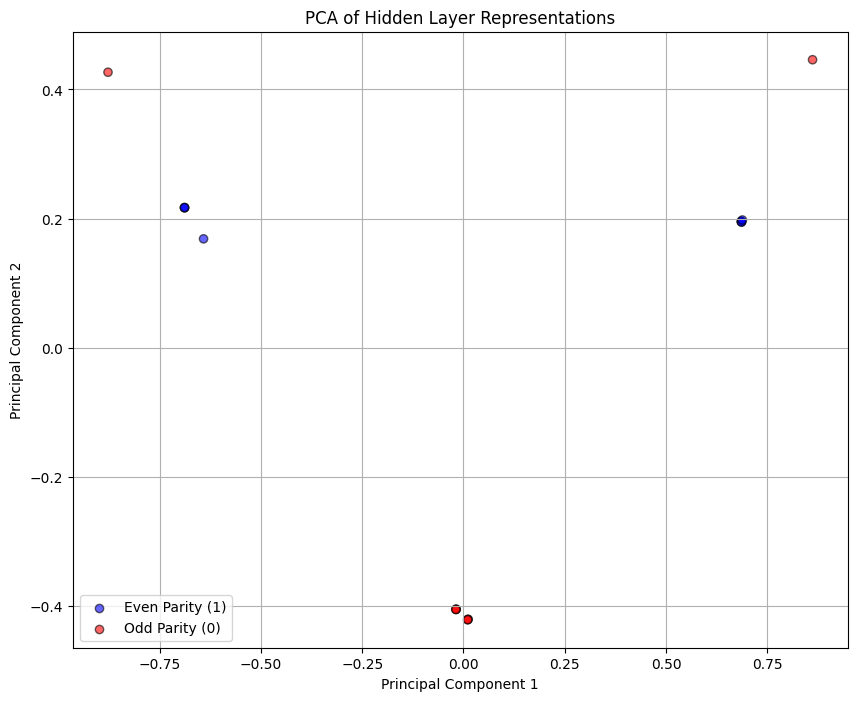

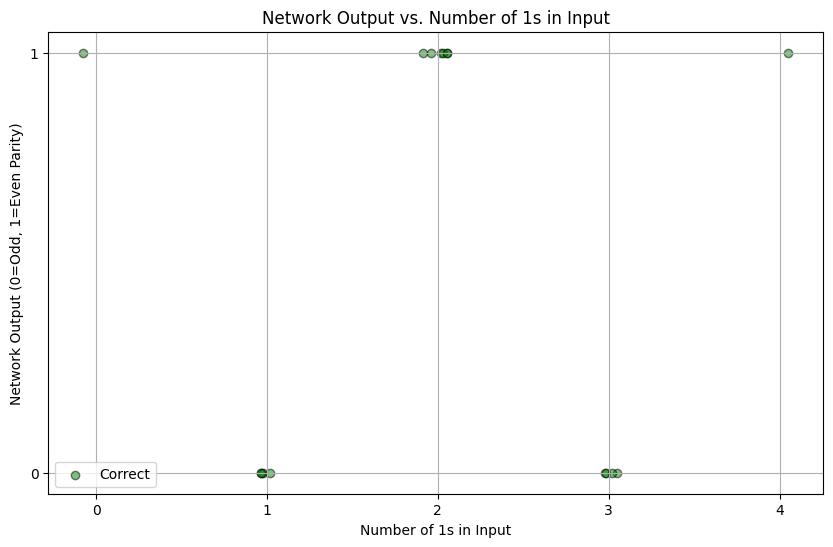

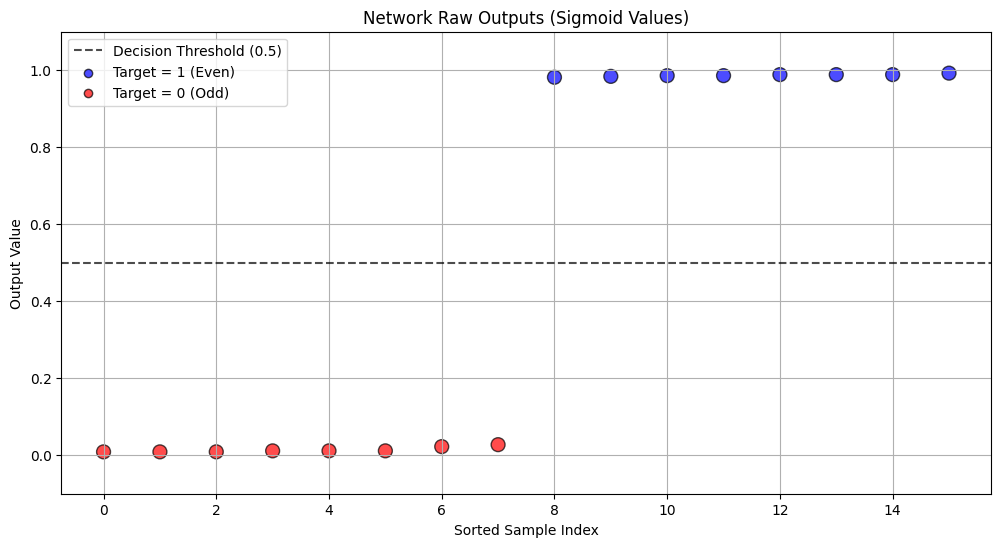


Best model had 4 hidden neurons with 100.00% accuracy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Sigmoid activation function and its derivative （Sigmoid函数&导数）
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    # x is already sigmoid(x), so this is y * (1 - y)
    return x * (1 - x)

# Generate all 16 combinations of 4-bit inputs, and append a dummy input (-1) （生成数据集）
def generate_parity_data():
    x = []
    y = []
    for i in range(16):
        bits = [int(b) for b in format(i, '04b')]
        parity = sum(bits) % 2
        output = 1 if parity == 0 else 0    # even parity -> 1, else -> 0 偶数为1；奇数为0
        x.append(bits + [-1])   # append dummy input -1 加上bias输入
        y.append([output])
    return np.array(x), np.array(y)

# Train the BP network 网络训练函数
def train_bp(x_train, y_train, hidden_size, epochs=10000, learning_rate=0.5):
    input_size = x_train.shape[1]   # 5 (4-bit + dummy input)
    output_size = y_train.shape[1]  # 1

    # Initialize weights with small random values 初始化权重
    np.random.seed(42)
    weights_input_hidden = np.random.uniform(-1, 1, (input_size, hidden_size))
    weights_hidden_output = np.random.uniform(-1, 1, (hidden_size, output_size))

    # For visualization
    error_history = []
    hidden_activations_final = None
    
    for epoch in range(epochs):
        # Forward propagation 正向传播
        hidden_input = np.dot(x_train, weights_input_hidden)    # shape: (16, hidden_size)
        hidden_output = sigmoid(hidden_input)                   # shape: (16, hidden_size)
        final_input = np.dot(hidden_output, weights_hidden_output)  # shape: (16, 1)
        final_output = sigmoid(final_input)                         # shape: (16, 1)
        
        # Save final hidden layer activations
        if epoch == epochs - 1:
            hidden_activations_final = hidden_output.copy()
        
        # Compute error 计算误差
        error = y_train - final_output                              # shape: (16, 1)
        total_error = np.sum(error**2)
        error_history.append(total_error)
        
        # Back propagation 反向传播
        d_output = error * sigmoid_derivative(final_output)         # shape: (16, 1)
        d_hidden = d_output.dot(weights_hidden_output.T) * sigmoid_derivative(hidden_output)  # shape: (16, hidden_size)
        
        # Update weights 权重更新
        weights_hidden_output += hidden_output.T.dot(d_output) * learning_rate
        weights_input_hidden += x_train.T.dot(d_hidden) * learning_rate
        
        # Print error every 1000 epochs
        if epoch % 1000 == 0:
            print(f" Epoch {epoch}, Error: {total_error:.6f}")
    
    return weights_input_hidden, weights_hidden_output, error_history, hidden_activations_final, final_output

# Evaluate the trained network 网络预测函数
def evaluate(x_test, weights_input_hidden, weights_hidden_output):
    hidden = sigmoid(np.dot(x_test, weights_input_hidden))  # shape: (16, hidden_size)
    output = sigmoid(np.dot(hidden, weights_hidden_output)) # shape: (16, 1)
    prediction = [1 if o >= 0.5 else 0 for o in output]
    return prediction, output, hidden

# Visualization functions
def plot_learning_curves(error_histories, hidden_sizes):
    plt.figure(figsize=(10, 6))
    for i, errors in enumerate(error_histories):
        # Plot every 100th point to avoid overcrowding
        plt.plot(range(0, len(errors), 100), errors[::100], label=f'{hidden_sizes[i]} neurons')
    
    plt.title('Learning Curves for Different Hidden Layer Sizes')
    plt.xlabel('Epoch')
    plt.ylabel('Total Squared Error')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Log scale for better visualization
    plt.savefig('parity4bit_learning_curves.png')
    plt.show()

def plot_accuracy_vs_hidden_size(accuracies, hidden_sizes):
    plt.figure(figsize=(8, 6))
    plt.plot(hidden_sizes, accuracies, 'bo-', linewidth=2)
    plt.title('Accuracy vs. Hidden Layer Size')
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.xticks(hidden_sizes)
    plt.savefig('parity4bit_accuracy_vs_hidden.png')
    plt.show()

def plot_hidden_activations(hidden_activations, y_train):
    # PCA to reduce dimensionality for visualization
    pca = PCA(n_components=2)
    hidden_2d = pca.fit_transform(hidden_activations)
    
    plt.figure(figsize=(10, 8))
    # Color by actual class (even/odd parity)
    colors = ['red' if y == 0 else 'blue' for y in y_train.flatten()]
    
    plt.scatter(hidden_2d[:, 0], hidden_2d[:, 1], c=colors, alpha=0.6, edgecolor='k')
    plt.title('PCA of Hidden Layer Representations')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    
    # Add a legend
    plt.scatter([], [], c='blue', alpha=0.6, edgecolor='k', label='Even Parity (1)')
    plt.scatter([], [], c='red', alpha=0.6, edgecolor='k', label='Odd Parity (0)')
    plt.legend()
    
    plt.savefig('parity4bit_hidden_pca.png')
    plt.show()

def plot_bit_count_vs_output(x_data, network_outputs, y_data):
    # Count number of 1s in each input
    bit_counts = np.sum(x_data[:, :-1], axis=1)  # Exclude bias term
    
    plt.figure(figsize=(10, 6))
    
    # Add slight jitter to avoid overlap
    jitter = np.random.normal(0, 0.05, size=len(bit_counts))
    
    # Get predictions (0 or 1)
    predictions = [1 if o >= 0.5 else 0 for o in network_outputs.flatten()]
    
    # Plot correct predictions
    correct_indices = [i for i in range(len(y_data)) if predictions[i] == y_data[i][0]]
    incorrect_indices = [i for i in range(len(y_data)) if predictions[i] != y_data[i][0]]
    
    plt.scatter(bit_counts[correct_indices] + jitter[correct_indices], 
                [predictions[i] for i in correct_indices], 
                alpha=0.5, c='green', edgecolor='k', label='Correct')
    
    # Plot incorrect predictions if any
    if incorrect_indices:
        plt.scatter(bit_counts[incorrect_indices] + jitter[incorrect_indices], 
                    [predictions[i] for i in incorrect_indices], 
                    alpha=0.5, c='red', edgecolor='k', label='Incorrect')
    
    plt.title('Network Output vs. Number of 1s in Input')
    plt.xlabel('Number of 1s in Input')
    plt.ylabel('Network Output (0=Odd, 1=Even Parity)')
    plt.yticks([0, 1])
    plt.xticks(range(5))  # 0-4 bits can be set to 1
    plt.grid(True)
    plt.legend()
    plt.savefig('parity4bit_bit_count_vs_output.png')
    plt.show()

def plot_raw_outputs(network_outputs, y_data):
    """Plot raw sigmoid outputs to see how confidently the network makes predictions"""
    plt.figure(figsize=(12, 6))
    
    # Sort by actual target value then by network output
    sorted_indices = sorted(range(len(y_data)), key=lambda i: (y_data[i][0], network_outputs[i][0]))
    
    # Create x-axis indices (0-15)
    x_indices = range(len(y_data))
    
    # Get sorted outputs and targets
    sorted_outputs = [network_outputs[i][0] for i in sorted_indices]
    sorted_targets = [y_data[i][0] for i in sorted_indices]
    
    # Plot sigmoid outputs
    plt.scatter(x_indices, sorted_outputs, c=['blue' if t == 1 else 'red' for t in sorted_targets], 
               alpha=0.7, edgecolor='k', s=100)
    
    # Plot decision threshold
    plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')
    
    # Plot target values
    plt.scatter([], [], c='blue', alpha=0.7, edgecolor='k', label='Target = 1 (Even)')
    plt.scatter([], [], c='red', alpha=0.7, edgecolor='k', label='Target = 0 (Odd)')
    
    plt.title('Network Raw Outputs (Sigmoid Values)')
    plt.xlabel('Sorted Sample Index')
    plt.ylabel('Output Value')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.legend()
    plt.savefig('parity4bit_raw_outputs.png')
    plt.show()

# Main program
if __name__ == "__main__":
    x_data, y_data = generate_parity_data()
    
    hidden_sizes = [4, 6, 8, 10]
    error_histories = []
    accuracies = []
    best_accuracy = 0
    best_hidden_size = 0
    best_hidden_activations = None
    best_outputs = None
    
    for hidden_neurons in hidden_sizes:
        print(f"\nTraining network with {hidden_neurons} hidden neurons:")
        w_ih, w_ho, error_history, hidden_activations, final_outputs = train_bp(x_data, y_data, hidden_neurons)
        predictions, outputs, hidden = evaluate(x_data, w_ih, w_ho)
        
        # Calculate accuracy
        accuracy = sum([int(predictions[i] == y_data[i][0]) for i in range(len(y_data))]) / len(y_data)
        print(f"Predictions: {predictions}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        
        error_histories.append(error_history)
        accuracies.append(accuracy * 100)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hidden_size = hidden_neurons
            best_hidden_activations = hidden_activations
            best_outputs = outputs
    
    # Generate essential visualizations
    print("\nGenerating visualizations...")
    
    # 1. Learning curves - shows training convergence for each network size
    plot_learning_curves(error_histories, hidden_sizes)
    
    # 2. Accuracy vs hidden size - shows relationship between network size and performance
    plot_accuracy_vs_hidden_size(accuracies, hidden_sizes)
    
    # 3. Hidden layer activations - shows how the network separates even/odd parity inputs
    plot_hidden_activations(best_hidden_activations, y_data)
    
    # 4. Bit count vs output - directly shows if the network learned the parity pattern
    plot_bit_count_vs_output(x_data, best_outputs, y_data)
    
    # 5. Raw outputs - shows how confidently the network makes its predictions
    plot_raw_outputs(best_outputs, y_data)
    
    print(f"\nBest model had {best_hidden_size} hidden neurons with {best_accuracy * 100:.2f}% accuracy")
    
    input("\nPress ENTER to exit...")